# Debugging a code that does not run

### Description of the physical system and the simulation

For the purpose of debugging a code, let's try to write a program simulating a chain of balls that are connected to their neighbors through springs (this is a very crude approximation of a string in a musical instrument):

![](sketch_system.png)

The positions of the $N$ balls are denoted by $\vec{x}_i$ ($i=1, \dots, N$), and the springs are characterized
by a spring constant $k$ and a rest distance $d_\mathrm{rest}$.

The potential energy in this system is given as
$$
U = \sum_{i=1}^{N-1} \frac{1}{2} k \left(\left|\vec{x}_i - \vec{x}_{i+1}\right| - d_\mathrm{rest}\right)^2.
$$

The force on ball $i$ from the surrounding balls is 

$$ F_{i} = \sum_{j=\{i-1, i+1\}} -k \left(\left|\vec{x}_i - \vec{x}_j\right| - d_\mathrm{rest}\right)  \frac{\vec{x}_i - \vec{x}_j}{\left|\vec{x}_i - \vec{x}_j\right|}$$

As mentioned above, we want to keep the two outermost balls fixed. We can achieve this by setting the forces $F_1=F_N=0$.
With this explicit form of the force we can solve Newton's equations of motion.

For given initial positions (and assuming the initial velocity is 0), this is done in the module `simulation`.

A code to do so, could look like that:

In [4]:
import numpy as np

SPRING_CONSTANT = 2
REST_DIST = 1


def simulate(pos_init, time, steps):
    """
    Simulate the motion of a chain of balls with springs using a symplectic Euler method.
    
    Parameters
    ----------
    pos_init:
        Nx2 array containing the initial positions of the N balls
    time:
        simulation time
    steps:
        number of discrete simulation time steps. The size of the time step is `time/steps`
    
    Returns
    -------
    pos_per_t:
        list of arrays with positions of the N balls for every discrete time step
    """
    pos = pos_init.copy()
    vel = np.zeros_like(pos)
    
    pos_per_t = []
    dt = time/steps
    
    E_tot = []
    
    for t in range(steps):
        force = spring_force(pos)
        vel = vel + dt * force
        pos = pos + dt * vel
        
        pos_per_t.append(pos)
        E_tot.append(total_energy(pos, vel))
        
    return pos_per_t, E_tot

In [10]:
def spring_force(pos):
    """
    Compute the force on each ball due to the springs connecting to the neighboring balls. The properties
    of the springs are described by the global constants SPRING_CONSTANT and REST_DIST.
    
    Parameters
    ----------
    pos:
        Nx2 array containing the positions of the N balls
        
    Returns
    -------
    force:
        Nx2 array containign the forces acting on each ball. The force on the outermost balls
        (that are held fixed) is set to zero.
    """
   
    f = np.zeros_like(pos)
    for i in range(1, len(pos)-1):
        # force from previous ball
        dist_vec = pos[i] - pos[i-1]
        dist = np.sqrt(np.sum(dist_vec**2))
        f[i] += - SPRING_CONSTANT (dist - REST_DIST)**2 * dist_vec/dist
        
        # force from the next ball
        dist_vec = pos[i] - pos
        dist = np.sqrt(np.sum(dist_vec**2))
        f[i] += - SPRING_CONSTANT * (dist - REST_DIST)**2 * dist_vec/dist
        
    return f

In [15]:
def total_energy(pos, vel):
    """
    Compute the total energy (kinetic + potential) of the system.
    
    Parameters
    ----------
    pos:
        Nx2 array containing the positions of the N balls
    vel: 
        Nx2 array containing the velocities of the N balls
    """
    
    E_tot = 0
    for i in range(1, len(pos)-1):
        E_tot += 0.5 * np.sum(vel[i]**2)
        
    for i in range(0, len(pos)-1):
        dist_vec = pos[i] - pos[i+1]
        dist = np.sqrt(np.sum(dist_vec**2))
        E_tot += 0.5 * SPRING_CONSTANT * (dist - REST_DIST)**2
        
    return E_tot

... except this code has a number of errors in it. Let's see what happens if we run it

## Reading a *traceback*

First, set up some initial conditions

In [7]:
import matplotlib.pyplot as plt

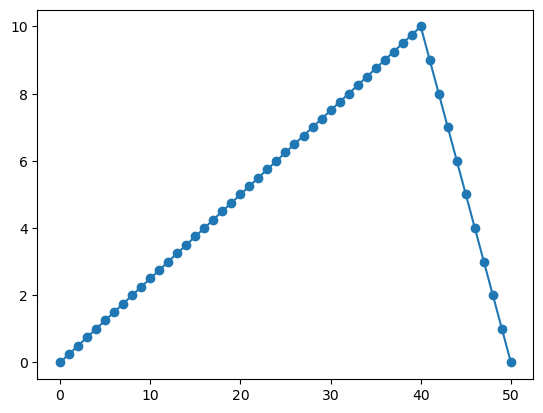

In [8]:
# Fill in the initial positions of the balls
N = 50

xs = np.arange(N+1)
ys = np.append(xs[:40] * 10/40, (50 - xs[40:])*10/10)
pos_init = np.stack([xs, ys], axis=1)

plt.plot(pos_init[:, 0], pos_init[:, 1], marker='o')
plt.show()

In [9]:
positions, energy = simulate(pos_init, 200.0, 2000)

TypeError: 'int' object is not callable

When we try to run the code, we get an error message. The last part is the actual error: `TypeError: 'int' object is not callable`. This error basically means that we tried to use an integer like a function, e.g. like that
```py
f = 1
f(1)
```
Obviously, this is not what we wanted to do, so most likely there is a typo somewhere.

Above the error message, you can see the *traceback* which shows the sequence of function calls that got you to the problem at hand. The lowest piece of the traceback shows us the code that raised the error (look for the line with `--->`) together with a few lines around it. The error is generated here:
```
---> 66 f[i] += - SPRING_CONSTANT (dist - REST_DIST)**2 * dist_vec/dist
```
Indeed here we see some code that looks like a function call after `SPRING_CONSTANT`, we simply forgot a `*` there!

In this case, we can immediately see where the error happened, and we don't need to go up in the traceback to see where it originated.

Let us now fix the error and see if our code now runs:

In [11]:
def spring_force(pos):
    """
    Compute the force on each ball due to the springs connecting to the neighboring balls. The properties
    of the springs are described by the global constants SPRING_CONSTANT and REST_DIST.
    
    Parameters
    ----------
    pos:
        Nx2 array containing the positions of the N balls
        
    Returns
    -------
    force:
        Nx2 array containign the forces acting on each ball. The force on the outermost balls
        (that are held fixed) is set to zero.
    """
   
    f = np.zeros_like(pos)
    for i in range(1, len(pos)-1):
        # force from previous ball
        dist_vec = pos[i] - pos[i-1]
        dist = np.sqrt(np.sum(dist_vec**2))
        f[i] += - SPRING_CONSTANT * (dist - REST_DIST)**2 * dist_vec/dist
        
        # force from the next ball
        dist_vec = pos[i] - pos
        dist = np.sqrt(np.sum(dist_vec**2))
        f[i] += - SPRING_CONSTANT * (dist - REST_DIST)**2 * dist_vec/dist
        
    return f

## Errors in a line - but another line is faulty

Let's run the code again

In [12]:
positions, energy = simulate(pos_init, 200.0, 2000)

ValueError: non-broadcastable output operand with shape (2,) doesn't match the broadcast shape (51,2)

Again, we get an error. This is an error coming from `numpy`, essentially telling us that we want to do some operation involving a vector of length 2 and a matrix of size 51x2. Again, the arrow points at where the error occurs
```
---> 28     f[i] += - SPRING_CONSTANT * (dist - REST_DIST)**2 * dist_vec/dist
```
Except here we are not dealing with a simple error we can find only in that line! The error occurs in that line, i.e. there are two numpy objects with incompatible shape in this line. However, to fix this we need to look into the code around it.

First, we need to figure out which object has the wrong size. This can be done using different methods

- add a couple of `print` statements to the code, printing various objects
- use a debugger, for example the debugger built into jupyter. With that one, we can see the values of the variables at different stages of the execution (see demonstration in class)

When we do this, we find that `dist_vec` is an array of shape `(51, 2)`, whereas it should have been a vector of length 2 (as our balls live in 2D space). When we look further in the code, we see that `dist_vec` is set in the line:
```
dist_vec = pos[i] - pos
```
where again we can easily spot a typo. The correct form should have been `dist_vec = pos[i] - pos[i+1]`. You might ask why that line worked at all? Why didn't the error occur in that line? The answer is tht numpy interpreted this line according to its [broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) that allow certain operations between objects of different shape (we will come back to this in the next lecture). So the problem was that you wrote code that formally was correct, but had a different result as intended.

Let's also fix this error

In [13]:
def spring_force(pos):
    """
    Compute the force on each ball due to the springs connecting to the neighboring balls. The properties
    of the springs are described by the global constants SPRING_CONSTANT and REST_DIST.
    
    Parameters
    ----------
    pos:
        Nx2 array containing the positions of the N balls
        
    Returns
    -------
    force:
        Nx2 array containign the forces acting on each ball. The force on the outermost balls
        (that are held fixed) is set to zero.
    """
   
    f = np.zeros_like(pos)
    for i in range(1, len(pos)-1):
        # force from previous ball
        dist_vec = pos[i] - pos[i-1]
        dist = np.sqrt(np.sum(dist_vec**2))
        f[i] += - SPRING_CONSTANT * (dist - REST_DIST)**2 * dist_vec/dist
        
        # force from the next ball
        dist_vec = pos[i] - pos[i+1]
        dist = np.sqrt(np.sum(dist_vec**2))
        f[i] += - SPRING_CONSTANT * (dist - REST_DIST)**2 * dist_vec/dist
        
    return f

## Going up the traceback

Let's run the code again:

In [16]:
positions, energy = simulate(pos_init, 200.0, 2000)

Hooray, the code now ran! Let us have a look at our hard-earned result, and make an animation:

In [21]:
from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots()
ax.set_xlim(( 0, 50))
ax.set_ylim((-10, 10))

line, = ax.plot([], [], lw=2, marker='o')

def init():
    line.set_data([], [])
    return (line,)


def animate(i):
    line.set_data(positions[i*10][:,0], positions[i*10][:])
    return (line,)

plt.close(fig) # Don't show the empty plot 

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

HTML(anim.to_jshtml())

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (51,) and arg 1 with shape (102,).

We obtain a very lengthy traceback! The actual error again tells us that some operation on numpy objects with incompatible shapes is attempted. But the error occurs apparently in a numpy function itself: If you look at filename of the last part of the traceback, we see a reference to 
```
--> 422 b = np.broadcast(*args[:32])
```
in file `numpy/lib/stride_tricks.py`. (Note that you might get a different error, depending on your version of matplotlib/numpy)

So did we now find a bug in numpy itself??

To figure out the problem, we now have to go upwards in the traceback to find the origin of the error. When we do so, we find more numpy functions, before we get to matplotlib functions until we find a piece of our code
```
---> 25 HTML(anim.to_jshtml())
```
So things go wrong when the animation is generated. Apparently, we feed somethign invalid to matplotlib. Looking a bit around in our code, we can find
```
    line.set_data(positions[i*10][:,0], positions[i*10][:])
```
where we see that we don't properly specify the y-coordinate. The correct code should be 
```
    line.set_data(positions[i*10][:,0], positions[i*10][:,1])
```
So why does matplotlib not give a more specific error message? Why does it try to work with invalid input and does not check the input? In Python, libraries often don't check for all possible errors in input (this is tedious, and you won't be able to think of all errors anyways), but rather tries if the input works! This is why you may get very lengthy tracebacks as above.

## Other examples of going up the traceback

There can be other reasons to go up the trace back. For example, when you call a funtion from different places in you code and an error occurs in that function, it can be useful to go up the traceback to figure out from *which* function call the error originated. It could easily be that the input at that point is wrong.